# Natural language processing for sarcasm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,6)

## Context

### From Rishabh Misra
#### https://rishabhmisra.github.io/publications/

Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

This new dataset has following advantages over the existing Twitter datasets:

* Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.

* Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

* Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.

In [3]:
import urllib
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

('sarcasm.json', <http.client.HTTPMessage at 0x1aeb98a1640>)

In [4]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [5]:
len(sentences), len(labels)

(26709, 26709)

In [45]:
np.random.seed(42)

for i in range(4):
    idx = np.random.choice(15000,1)[0]
    print(sentences[idx], "--> Sarcastic?: {}".format("Yes" if labels[idx] == 1 else "No"))
    print()

8 awesome (yes, awesome!) things about toddlers --> Sarcastic?: No

14 photos that show the special bond between moms and daughters --> Sarcastic?: No

nation curious after discovering mysterious, eccentric benefactor paid off country's debt in full --> Sarcastic?: Yes

irish wake a blur --> Sarcastic?: Yes



In [7]:
vocab_size = 1500
embedding_dim = 32
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
train_size = 19000

train_sentences = sentences[0:train_size]
test_sentences = sentences[train_size:]
train_labels = labels[0:train_size]
test_labels = labels[train_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

train_seq = tokenizer.texts_to_sequences(train_sentences)
train_seq = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_seq = tokenizer.texts_to_sequences(test_sentences)
test_seq = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_labels, test_labels = np.array(train_labels), np.array(test_labels)

In [8]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(35, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 20
history = model.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(test_seq, test_labels))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 32)           48000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 35)                1155      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 36        
Total params: 49,191
Trainable params: 49,191
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
594/594 [==============================] - 1s 1ms/step - loss: 0.6495 - accuracy: 0.6174 - val_loss: 0.5365 - val_accuracy: 0.7295
Epoch 2/20
594/594 [==============================] - 1s 1ms/step - loss: 0.4379 - accuracy: 0.8041 - val_lo

In [16]:
def loss_plot(history):
    df = pd.DataFrame(history.history)
    df.plot(color=['blue', 'purple', 'black', 'red'])
    plt.legend(['Train loss', 'Accuracy','Validation loss', 'Validation accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title("Training and validation accuracy and loss by Epoch")
    plt.show()

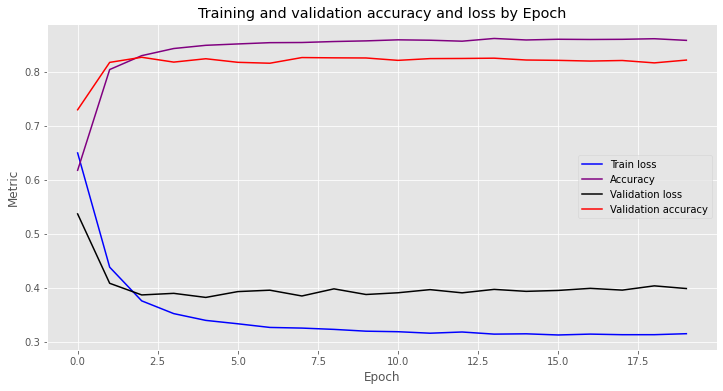

In [28]:
loss_plot(history)

In [15]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model1 = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.LSTM(32),
    keras.layers.Dense(35, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 20
history1 = model1.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(test_seq, test_labels))

Epoch 1/20
594/594 [==============================] - 16s 24ms/step - loss: 0.6866 - accuracy: 0.5598 - val_loss: 0.6852 - val_accuracy: 0.5638
Epoch 2/20
594/594 [==============================] - 14s 24ms/step - loss: 0.6862 - accuracy: 0.5599 - val_loss: 0.6850 - val_accuracy: 0.5638
Epoch 3/20
594/594 [==============================] - 14s 24ms/step - loss: 0.6862 - accuracy: 0.5599 - val_loss: 0.6858 - val_accuracy: 0.5638
Epoch 4/20
594/594 [==============================] - 15s 25ms/step - loss: 0.6861 - accuracy: 0.5599 - val_loss: 0.6856 - val_accuracy: 0.5638
Epoch 5/20
594/594 [==============================] - 15s 26ms/step - loss: 0.6861 - accuracy: 0.5599 - val_loss: 0.6852 - val_accuracy: 0.5638
Epoch 6/20
594/594 [==============================] - 15s 25ms/step - loss: 0.6861 - accuracy: 0.5599 - val_loss: 0.6852 - val_accuracy: 0.5638
Epoch 7/20
594/594 [==============================] - 16s 26ms/step - loss: 0.6862 - accuracy: 0.5599 - val_loss: 0.6850 - val_accuracy:

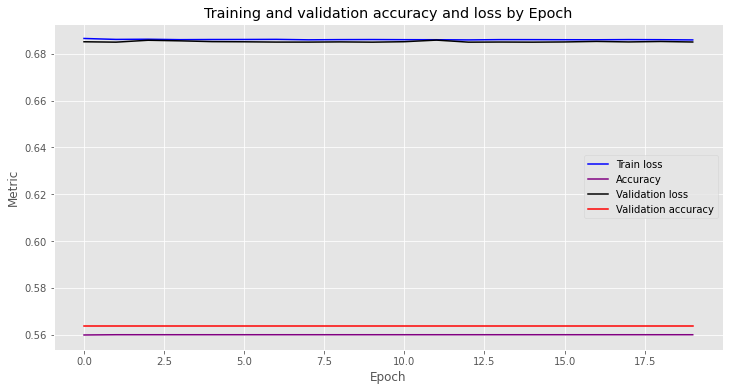

In [17]:
loss_plot(history1)

In [18]:
model2 = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 20
history2 = model2.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(test_seq, test_labels))

Epoch 1/20
594/594 [==============================] - 22s 32ms/step - loss: 0.4287 - accuracy: 0.7883 - val_loss: 0.3704 - val_accuracy: 0.8225
Epoch 2/20
594/594 [==============================] - 18s 31ms/step - loss: 0.3239 - accuracy: 0.8555 - val_loss: 0.3570 - val_accuracy: 0.8415
Epoch 3/20
594/594 [==============================] - 19s 31ms/step - loss: 0.2935 - accuracy: 0.8693 - val_loss: 0.3510 - val_accuracy: 0.8419
Epoch 4/20
594/594 [==============================] - 18s 31ms/step - loss: 0.2688 - accuracy: 0.8829 - val_loss: 0.3598 - val_accuracy: 0.8377
Epoch 5/20
594/594 [==============================] - 18s 30ms/step - loss: 0.2502 - accuracy: 0.8916 - val_loss: 0.3814 - val_accuracy: 0.8414
Epoch 6/20
594/594 [==============================] - 17s 29ms/step - loss: 0.2331 - accuracy: 0.9014 - val_loss: 0.4038 - val_accuracy: 0.8315
Epoch 7/20
594/594 [==============================] - 17s 29ms/step - loss: 0.2165 - accuracy: 0.9076 - val_loss: 0.3976 - val_accuracy:

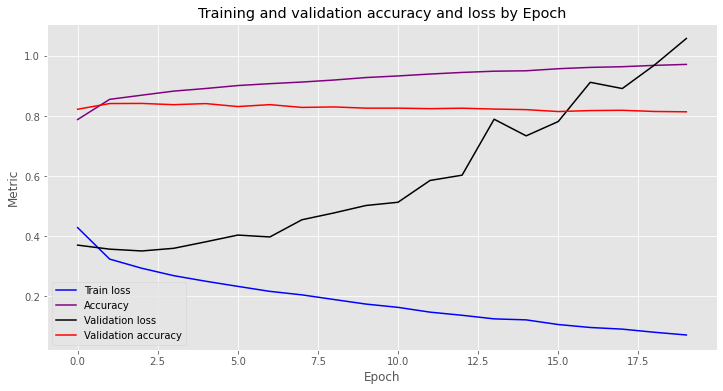

In [19]:
loss_plot(history2)

In [20]:
model3 = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, activation='relu'),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 20
history3 = model3.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(test_seq, test_labels))

Epoch 1/20
594/594 [==============================] - 2s 3ms/step - loss: 0.4721 - accuracy: 0.7581 - val_loss: 0.3899 - val_accuracy: 0.8190
Epoch 2/20
594/594 [==============================] - 2s 3ms/step - loss: 0.3158 - accuracy: 0.8615 - val_loss: 0.3746 - val_accuracy: 0.8343
Epoch 3/20
594/594 [==============================] - 2s 3ms/step - loss: 0.2544 - accuracy: 0.8941 - val_loss: 0.4021 - val_accuracy: 0.8257
Epoch 4/20
594/594 [==============================] - 2s 3ms/step - loss: 0.1976 - accuracy: 0.9218 - val_loss: 0.4560 - val_accuracy: 0.8215
Epoch 5/20
594/594 [==============================] - 2s 3ms/step - loss: 0.1498 - accuracy: 0.9454 - val_loss: 0.5188 - val_accuracy: 0.8167
Epoch 6/20
594/594 [==============================] - 2s 3ms/step - loss: 0.1093 - accuracy: 0.9612 - val_loss: 0.6185 - val_accuracy: 0.8097
Epoch 7/20
594/594 [==============================] - 2s 3ms/step - loss: 0.0751 - accuracy: 0.9753 - val_loss: 0.7356 - val_accuracy: 0.8076
Epoch 

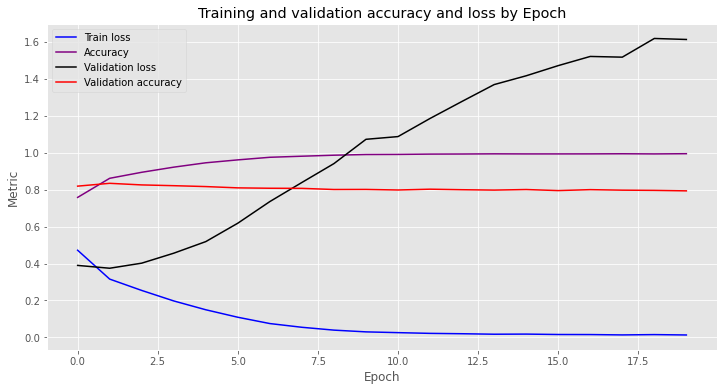

In [21]:
loss_plot(history3)

In [22]:
model4 = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 20
history4 = model4.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(test_seq, test_labels))

Epoch 1/20
594/594 [==============================] - 22s 32ms/step - loss: 0.4295 - accuracy: 0.7881 - val_loss: 0.3680 - val_accuracy: 0.8258
Epoch 2/20
594/594 [==============================] - 19s 32ms/step - loss: 0.3236 - accuracy: 0.8552 - val_loss: 0.3553 - val_accuracy: 0.8408
Epoch 3/20
594/594 [==============================] - 20s 33ms/step - loss: 0.2926 - accuracy: 0.8699 - val_loss: 0.3607 - val_accuracy: 0.8384
Epoch 4/20
594/594 [==============================] - 19s 32ms/step - loss: 0.2715 - accuracy: 0.8827 - val_loss: 0.3654 - val_accuracy: 0.8333
Epoch 5/20
594/594 [==============================] - 19s 33ms/step - loss: 0.2550 - accuracy: 0.8908 - val_loss: 0.3808 - val_accuracy: 0.8362
Epoch 6/20
594/594 [==============================] - 20s 33ms/step - loss: 0.2374 - accuracy: 0.9003 - val_loss: 0.3860 - val_accuracy: 0.8319
Epoch 7/20
594/594 [==============================] - 20s 33ms/step - loss: 0.2188 - accuracy: 0.9103 - val_loss: 0.3872 - val_accuracy:

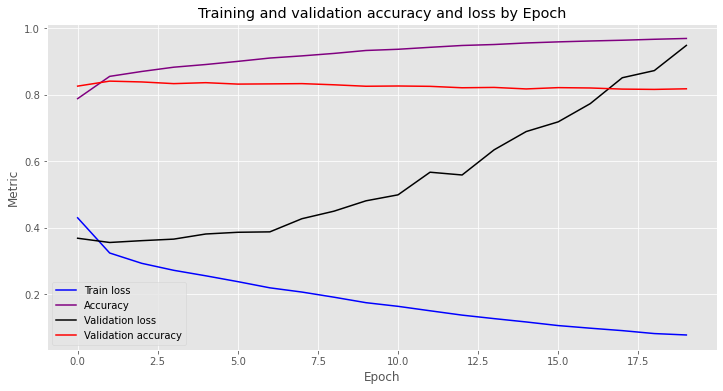

In [23]:
loss_plot(history4)

In [24]:
class MyCallbacks(keras.callbacks.Callback):
    def end_epoch(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.9:
            print("Training ended! Accuracy achieved")
            self.model.stop_training = True

In [29]:
model5 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Conv1D(filters=64, kernel_size=5, strides=2, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Conv1D(filters=128, kernel_size=5, strides=2, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 10
history4 = model4.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(test_seq, test_labels))

Epoch 1/10
594/594 [==============================] - 22s 32ms/step - loss: 0.0423 - accuracy: 0.9821 - val_loss: 1.6055 - val_accuracy: 0.8017
Epoch 2/10
594/594 [==============================] - 19s 32ms/step - loss: 0.0289 - accuracy: 0.9863 - val_loss: 1.6488 - val_accuracy: 0.8100
Epoch 3/10
594/594 [==============================] - 22s 36ms/step - loss: 0.0266 - accuracy: 0.9875 - val_loss: 1.8568 - val_accuracy: 0.8059
Epoch 4/10
594/594 [==============================] - 19s 33ms/step - loss: 0.0331 - accuracy: 0.9857 - val_loss: 1.7135 - val_accuracy: 0.8032
Epoch 5/10
594/594 [==============================] - 20s 34ms/step - loss: 0.0323 - accuracy: 0.9859 - val_loss: 1.8241 - val_accuracy: 0.8043
Epoch 6/10
594/594 [==============================] - 19s 32ms/step - loss: 0.0250 - accuracy: 0.9892 - val_loss: 1.9365 - val_accuracy: 0.8036
Epoch 7/10
594/594 [==============================] - 19s 32ms/step - loss: 0.0261 - accuracy: 0.9892 - val_loss: 1.8925 - val_accuracy:

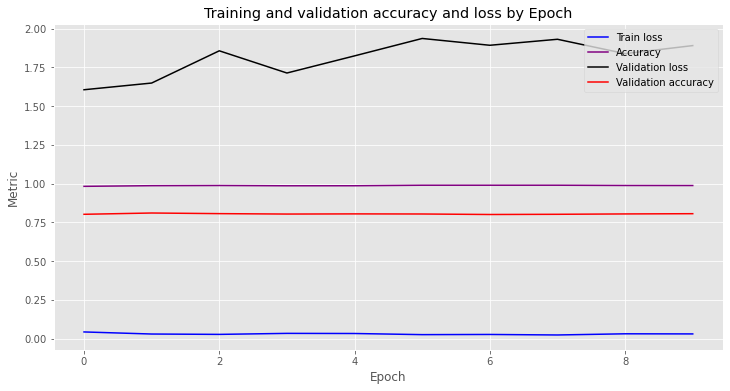

In [30]:
loss_plot(history4)

In [31]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model5 = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
model5.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])


mycallbacks = MyCallbacks()

num_epochs = 100
history5 = model5.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(test_seq, test_labels), callbacks=[mycallbacks])

Epoch 1/100
594/594 [==============================] - 1s 1ms/step - loss: 0.6491 - accuracy: 0.6116 - val_loss: 0.5266 - val_accuracy: 0.7181
Epoch 2/100
594/594 [==============================] - 1s 1ms/step - loss: 0.4542 - accuracy: 0.7923 - val_loss: 0.4494 - val_accuracy: 0.7884
Epoch 3/100
594/594 [==============================] - 1s 1ms/step - loss: 0.4035 - accuracy: 0.8187 - val_loss: 0.4352 - val_accuracy: 0.7984
Epoch 4/100
594/594 [==============================] - 1s 1ms/step - loss: 0.3822 - accuracy: 0.8313 - val_loss: 0.3836 - val_accuracy: 0.8293
Epoch 5/100
594/594 [==============================] - 1s 1ms/step - loss: 0.3688 - accuracy: 0.8353 - val_loss: 0.3829 - val_accuracy: 0.8248
Epoch 6/100
594/594 [==============================] - 1s 1ms/step - loss: 0.3608 - accuracy: 0.8408 - val_loss: 0.4092 - val_accuracy: 0.7996
Epoch 7/100
594/594 [==============================] - 1s 1ms/step - loss: 0.3528 - accuracy: 0.8444 - val_loss: 0.3881 - val_accuracy: 0.8211

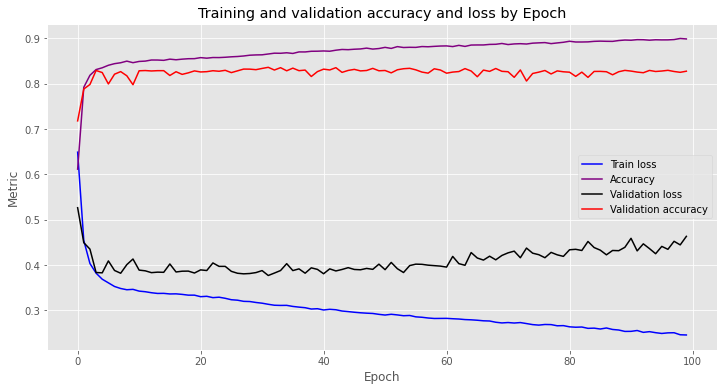

In [32]:
loss_plot(history5)

In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5, restore_best_weights=True)

model6 = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, activation='relu'),
    keras.layers.MaxPool1D(),
    keras.layers.Conv1D(filters=64, kernel_size=5, strides=2, activation='relu'),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
model6.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])


num_epochs = 100
history6 = model6.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(test_seq, test_labels), callbacks=[early_stop])

Epoch 1/100
594/594 [==============================] - 3s 4ms/step - loss: 0.5094 - accuracy: 0.7345 - val_loss: 0.3897 - val_accuracy: 0.8251
Epoch 2/100
594/594 [==============================] - 2s 4ms/step - loss: 0.3545 - accuracy: 0.8463 - val_loss: 0.3721 - val_accuracy: 0.8368
Epoch 3/100
594/594 [==============================] - 2s 4ms/step - loss: 0.3180 - accuracy: 0.8635 - val_loss: 0.3775 - val_accuracy: 0.8288
Epoch 4/100
594/594 [==============================] - 2s 4ms/step - loss: 0.2923 - accuracy: 0.8747 - val_loss: 0.3644 - val_accuracy: 0.8398
Epoch 5/100
594/594 [==============================] - 2s 4ms/step - loss: 0.2706 - accuracy: 0.8867 - val_loss: 0.3815 - val_accuracy: 0.8389
Epoch 6/100
594/594 [==============================] - 2s 4ms/step - loss: 0.2499 - accuracy: 0.8966 - val_loss: 0.3978 - val_accuracy: 0.8259
Epoch 7/100
594/594 [==============================] - 2s 4ms/step - loss: 0.2305 - accuracy: 0.9053 - val_loss: 0.3784 - val_accuracy: 0.8393

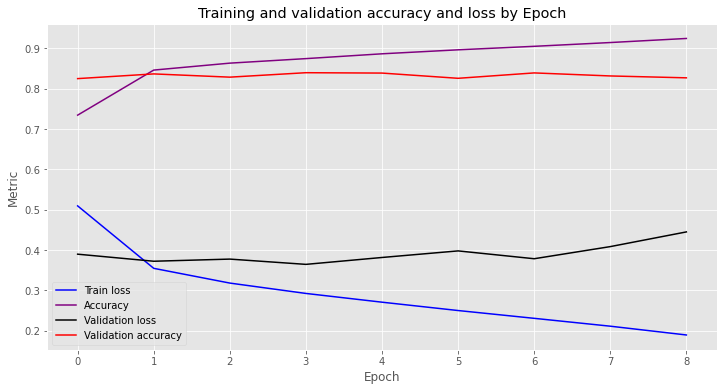

In [37]:
loss_plot(history6)